In [3]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'

In [4]:
scen_labels_ = pd.read_csv('cost_scenario_labels.csv') 
tech_labels_ = pd.read_csv('technology_labels.csv') 

In [42]:
# Grab data from databases for plotting GHG emissions
def _load_GHG_emissions(scen_labels_):

    # Load GHG emissions table and process them from database
    def __load_GHG_from_csv(df_, scenario):

        df_['carbon_emissions_tons'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['carbon_emissions_tons']

        df_ = df_[['period', 'load_zone', 'carbon_emissions_tons']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                                                          
        df_['scenario'] = scenario     
        
        return df_
    
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['static_load_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['static_load_mw']

        df_ = df_[['period', 'load_zone', 'static_load_mw']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_.rename(columns = {'static_load_mw': 'load_mw'})

    dfs_  = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name  = r'{}/{}'.format(path, scen)
        # Load GHG emissions from cvs files
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        emissions_ = __load_GHG_from_csv(dispatch_, scen)
        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)

        dfs_.append(pd.merge(emissions_, load_, on  = ['period', 'load_zone', 'scenario'])
    
    df_                          = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']                = df_['period'].astype(int)
    df_['carbon_emissions_tons'] = df_['carbon_emissions_tons'].astype(float)
    df_['load_mw']               = df_['load_mw'].astype(float)
    
    return df_

emissions_ = _load_GHG_emissions(scen_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


In [53]:
def _group_emissions_by_zone(df_, scen_labels_, columns_ = ['period', 'scenario', 'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], 
                          scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                          = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']                = df_['period'].astype(int)
    df_['carbon_emissions_tons'] = df_['carbon_emissions_tons'].astype(float)
    df_['load_mw']               = df_['load_mw'].astype(float)

    return df_

grouped_emissions_ = _group_emissions_by_zone(emissions_, scen_labels_)

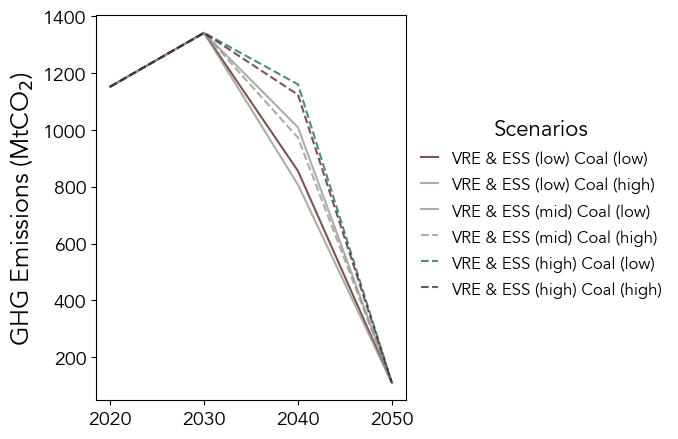

In [54]:
# Plot GHG emissions for different scenarios
def _plot_carbon_emissions(ax, df_, scen_labels_, title  = '', 
                                                  units  = 1e6,
                                                  legend = False):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['carbon_emissions_tons'].to_numpy()
        
        ax.plot(x_[idx_], y_[idx_]/units, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)

    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'GHG Emissions (MtCO$_2$)', fontsize = 18)
    #ax.set_ylim(0, 100)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenarios',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    plt.title(title, fontsize = 18, 
                     y        = 0.9125)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot GHG emissions for different scenarios
_plot_carbon_emissions(_ax, grouped_emissions_, scen_labels_, legend = True)

plt.savefig(path_to_images + 'GHG_emissions.png', bbox_inches = 'tight', 
                                                  dpi         = 300)

plt.show()

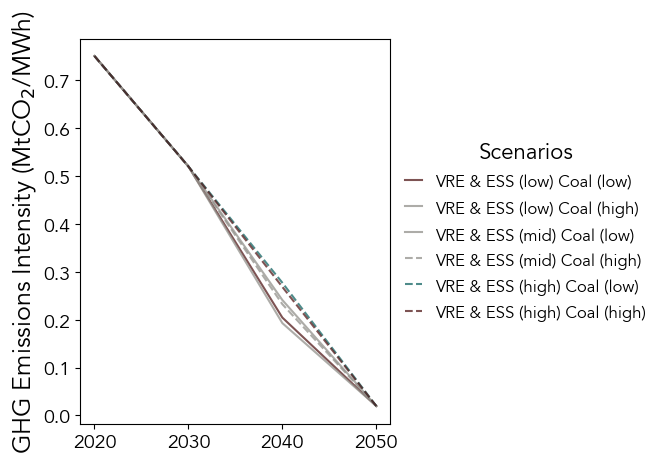

In [55]:
# Plot GHG emissions for different scenarios
def _plot_carbon_emissions_intesity(ax, df_, scen_labels_, title  = '', 
                                                           legend = False):

    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['carbon_emissions_tons'].to_numpy()
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/z_[idx_], 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)

    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'GHG Emissions Intensity (MtCO$_2$/MWh)', fontsize = 18)
    #ax.set_ylim(0, .1)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenarios',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    plt.title(title, fontsize = 18, 
                     y        = 0.9125)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot GHG emissions for different scenarios
_plot_carbon_emissions_intesity(_ax, grouped_emissions_, scen_labels_, legend = True)

plt.savefig(path_to_images + 'GHG_emissions_intensity.png', bbox_inches = 'tight', 
                                                            dpi         = 300)

plt.show()

In [146]:
# Grab data from databases for plotting LCOE emissions
def _load_cost(scen_labels_):
    # Load fuel, and operation and maintanace cost table and process data from database
    def __load_vr_cost_from_csv(df_, scenario):
        
        df_['variable_om_cost'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['variable_om_cost']
         
        df_ = df_[['period', 'load_zone', 'variable_om_cost']]
        df_ = df_.rename(columns = {'variable_om_cost': 'variable_cost'})
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_

    # Load fix capacity cost table and process data from database
    def __load_fx_cost_from_csv(project_, new_, spec_, scenario):
        
        new_ = new_.fillna({'capacity_cost': 0, 'fixed_cost': 0})
        
        new_['new_fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']

        new_ = new_[['period', 'load_zone', 'new_fixed_cost']]
        new_ = new_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                                 
        spec_['spec_fixed_cost'] = spec_['fixed_cost_per_mw_yr'] 

        spec_ = pd.merge(spec_, project_, on = ['project'])
        spec_ = spec_[['period', 'load_zone', 'spec_fixed_cost']]
        spec_ = spec_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_               = pd.merge(new_, spec_, on = ['period', 'load_zone'])
        df_['fixed_cost'] = df_['new_fixed_cost'] + spec_['spec_fixed_cost']
        df_               = df_[['period', 'load_zone', 'fixed_cost']]
        df_['scenario']   = scenario    

        return df_

    # Load transmission capacity cost table and process data from database
    def __load_tx_cost_from_csv(project_, new_, spec_, scenario):

        new_['fixed_cost'] = new_['capacity_cost'] + new_['fixed_cost']
        
        new_ = new_[['period', 'load_zone_from', 'fixed_cost']]
        new_ = new_.rename(columns = {'load_zone_from': 'load_zone', 'fixed_cost': 'tx_cost'})
        new_ = new_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
        
        new_['scenario'] = scenario    
            
        project_['transmission_line'] = project_['transmission_line'].str.replace('_new', '')
        spec_                         = pd.merge(spec_, project_, on = ['transmission_line'])
        spec_                         = spec_[['period', 'transmission_line', 'tx_annualized_real_cost_per_mw_yr', 'specified_tx_max_mw']]
        spec_['transmission_line']    = spec_['transmission_line'].apply(lambda x: x.split("-")[0])
        spec_                         = spec_.rename(columns = {'transmission_line': 'load_zone'})
        spec_['spec_tx_cost']         = spec_['tx_annualized_real_cost_per_mw_yr'] * spec_['specified_tx_max_mw']
        spec_                         = spec_[['period', 'load_zone', 'spec_tx_cost']]

        df_             = pd.merge(new_, spec_, on = ['period', 'load_zone'])
        df_['tx_cost']  = df_['tx_cost'] + spec_['spec_tx_cost']
        df_             = df_[['period', 'load_zone', 'tx_cost']]
        df_['scenario'] = scenario    
        
        return df_

    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario):
        
        df_['total_power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['total_power_mw']

        df_ = df_[['period', 'load_zone', 'total_power_mw']]
        df_ = df_.groupby(['period', 'load_zone']).sum().reset_index(drop = False)
                         
        df_['scenario'] = scenario     

        return df_.rename(columns = {'total_power_mw': 'load_mw'})

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, path in zip(scen_labels_['scenario'], scen_labels_['path']):
        print(scen, path)
        dir_name = r'{}/{}'.format(path, scen)        

        # Load energy demand from csv files
        load_ = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        load_ = __load_demand_from_csv(load_, scen)
        # Load fix costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/project_period.csv', low_memory = False)
        spec_    = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_ = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        fx_      = __load_fx_cost_from_csv(project_, new_, spec_, scen)
        # Load variables costs from csv files
        vr_ = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        vr_ = __load_vr_cost_from_csv(vr_, scen)
        # Load tx costs from csv files
        new_     = pd.read_csv(dir_name + f'/results/transmission_period.csv', low_memory = False) 
        spec_    = pd.read_csv(dir_name + r'/inputs/specified_transmission_line_capacities.tab', sep = '\t', engine = 'python')        
        project_ = pd.read_csv(dir_name + r'/inputs/new_build_transmission_vintage_costs.tab', sep = '\t', engine = 'python')
        tx_      = __load_tx_cost_from_csv(project_, new_, spec_, scen)
        
        df_1_ = pd.merge(vr_, fx_, on = ['scenario', 'period', 'load_zone'])
        df_2_ = pd.merge(tx_, load_, on = ['scenario', 'period', 'load_zone'])
        df_   = pd.merge(df_1_, df_2_, on = ['scenario', 'period', 'load_zone'])

        dfs_.append(df_)
    
    df_                  = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']        = df_['period'].astype(int)
    df_['load_mw']       = df_['load_mw'].astype(float)
    df_['tx_cost']       = df_['tx_cost'].astype(float)
    df_['fixed_cost']    = df_['fixed_cost'].astype(float)
    df_['variable_cost'] = df_['variable_cost'].astype(float)

    return df_

cost_ = _load_cost(scen_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid /Users/Guille/Desktop/india_power/scenarios/cost


KeyboardInterrupt: 

In [145]:
def _group_cost_by_zone(df_, scen_labels_, columns_ = ['period', 'scenario', 'load_zone']):
    
    dfs_ = []
    # Open connection: open database and grab meta-data
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):
        
        df_p_ = df_.loc[df_['scenario'] == scen].copy()
        
        idx_ = df_p_['load_zone'] == zone
        
        if idx_.sum() == 0.:
            df_p_['load_zone'] = 'all'
        else:
            df_p_ = df_p_.loc[idx_].reset_index(drop = True)
        
        dfs_.append(df_p_.groupby(columns_).sum().reset_index(drop = False))
        
    df_                  = pd.concat(dfs_, axis = 0).reset_index(drop = True)
    df_['period']        = df_['period'].astype(int)
    df_['load_mw']       = df_['load_mw'].astype(float)
    df_['tx_cost']       = df_['tx_cost'].astype(float)
    df_['fixed_cost']    = df_['fixed_cost'].astype(float)
    df_['variable_cost'] = df_['variable_cost'].astype(float)

    return df_

grouped_cost_ = _group_cost_by_zone(cost_, scen_labels_)
print(grouped_cost_)

    period                                           scenario load_zone  \
0     2020  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
1     2030  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
2     2040  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
3     2050  VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
4     2020  VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...       all   
5     2030  VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...       all   
6     2040  VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...       all   
7     2050  VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90...       all   
8     2020  VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
9     2030  VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
10    2040  VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
11    2050  VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90C...       all   
12    2020  VREmid_STmid_

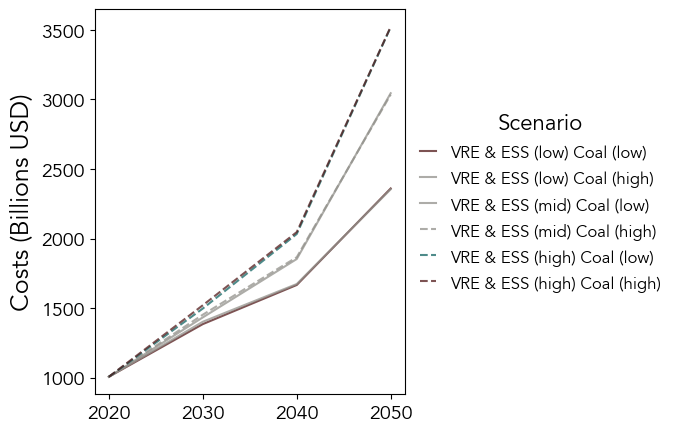

In [143]:
# Plot system cost for different scenarios
def _plot_total_cost(ax, df_, scen_labels_, legend = False,
                                             units  = 1e9,
                                             title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['variable_cost'].to_numpy() + data_['fixed_cost'].to_numpy() + data_['tx_cost'].to_numpy() 
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/units, 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    #ax.set_ylabel(r'Costs (USD per MWh)', fontsize = 18)
    ax.set_ylabel(r'Costs (Billions USD)', fontsize = 18)

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    plt.title(title, fontsize = 18, 
                     y        = 0.9125)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot system cost for different scenarios
_plot_total_cost(_ax, grouped_cost_, scen_labels_, legend = True)

plt.savefig(path_to_images + 'cost.png', bbox_inches = 'tight', 
                                         dpi         = 300)

plt.show()

[63.73583819 56.65450027 41.94600927 42.75575983]
[63.73584227 56.52500449 42.17636445 42.6751499 ]
[63.73585259 58.84357513 46.94219977 54.67949533]
[63.73583431 58.90504989 46.84721362 54.22206151]
[63.73585    61.6870486  52.03679408 62.26099441]
[63.73583656 62.09849357 52.20578131 62.49778548]


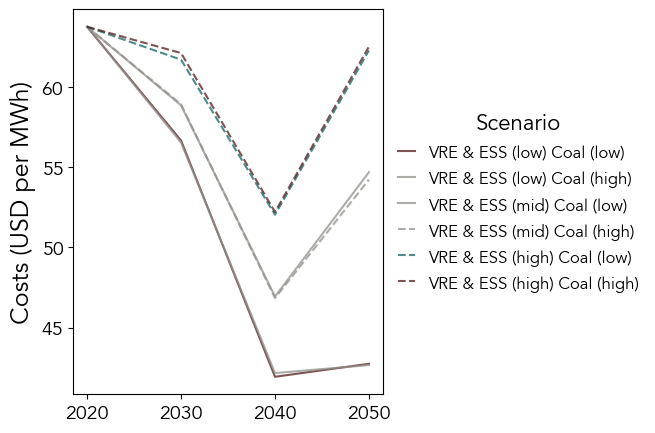

In [144]:
# Plot levelized cost of electricity for different scenarios
def _plot_levelized_cost(ax, df_, scen_labels_, legend = False,
                                                title  = ''):
    
    for scen, zone in zip(scen_labels_['scenario'], scen_labels_['zone']):    

        data_ = df_.loc[(df_['scenario'] == scen) & (df_['load_zone'] == zone)].copy()        
        idx_  = np.argsort(data_['period'].to_numpy())
        x_    = data_['period'].to_numpy()
        y_    = data_['variable_cost'].to_numpy() + data_['fixed_cost'].to_numpy() + data_['tx_cost'].to_numpy() 
        z_    = data_['load_mw'].to_numpy()

        ax.plot(x_[idx_], y_[idx_]/z_[idx_], 
                color     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'color'].to_numpy()[0], 
                linestyle = scen_labels_.loc[scen_labels_['scenario'] == scen, 'linestyle'].to_numpy()[0],
                label     = scen_labels_.loc[scen_labels_['scenario'] == scen, 'label'].to_numpy()[0],
                marker    = scen_labels_.loc[scen_labels_['scenario'] == scen, 'marker'].to_numpy()[0],
                linewidth = 1.5, 
                alpha     = 0.75)
    
    ax.set_xticks(x_[idx_], x_[idx_])
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(r'Costs (USD per MWh)', fontsize = 18)

    #ax.set_ylim(40, 75)

    if legend:
        ax.legend(loc            = 'center left', 
                  title          = 'Scenario',
                  bbox_to_anchor = (1, 0.5), 
                  frameon        = False,
                  title_fontsize = 16,
                  prop           = {'size': 12})
    
    plt.title(title, fontsize = 18, 
                     y        = 0.9125)

fig = plt.figure(figsize = (4., 5))
_ax  = plt.subplot(111)
    
# Plot levelized cost of electricity for different scenarios
_plot_levelized_cost(_ax, grouped_cost_, scen_labels_, legend = True)

plt.savefig(path_to_images + 'cost.png', bbox_inches = 'tight', 
                                         dpi         = 300)

plt.show(